In [1]:
import pickle
df = pickle.load(open('dataframe.pkl', 'rb'))
df.shape

(10785, 1126)

In [2]:
encode_me = [x for x in df.keys() if 'object' in str(df[x].dtype)]
for x in encode_me:
    df[x] = df.groupby(x)['home_team_win'].apply(lambda x:x.rolling(180).mean()).shift(1)

In [3]:
df = df.sort_values(by='date').copy().reset_index(drop=True)
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

X_train = X[:-1000]
y_train = y[:-1000]
X_valid = X[-1000:-500]
y_valid = y[-1000:-500]
X_test = X[-500:]
y_test = y[-500:]

In [4]:
import xgboost as xgb
params = {'learning_rate': 0.05,'max_depth': 5}
gbm = xgb.XGBClassifier(**params)
model = gbm.fit(X_train, y_train,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                eval_metric='logloss',
                early_stopping_rounds=10)
xgb_test_preds = model.predict(X_test)
xgb_test_proba = model.predict_proba(X_test)[:,1]

C:\Users\Aaron\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68938	validation_1-logloss:0.69134
[1]	validation_0-logloss:0.68602	validation_1-logloss:0.69110
[2]	validation_0-logloss:0.68291	validation_1-logloss:0.68972
[3]	validation_0-logloss:0.67976	validation_1-logloss:0.68887
[4]	validation_0-logloss:0.67688	validation_1-logloss:0.68851
[5]	validation_0-logloss:0.67431	validation_1-logloss:0.68695
[6]	validation_0-logloss:0.67122	validation_1-logloss:0.68641
[7]	validation_0-logloss:0.66839	validation_1-logloss:0.68617
[8]	validation_0-logloss:0.66579	validation_1-logloss:0.68577
[9]	validation_0-logloss:0.66303	validation_1-logloss:0.68564
[10]	validation_0-logloss:0.66045	validation_1-logloss:0.68614
[11]	validation_0-logloss:0.65783	validation_1-logloss:0.68571
[12]	validation_0-logloss:0.65548	validation_1-logloss:0.68647
[13]	validation_0-logloss:0.65310	validation_1-logloss:0.68643
[14]	validation_0-logloss:0.65058	validation_1-logloss:0.68592
[15]	validation_0-logloss:0.64827	validation_1-logloss:0.68551
[1

In [5]:
import xgboost as xgb
params = {'learning_rate': 0.05,'max_depth': 5}
gbm = xgb.XGBClassifier(**params)
model = gbm.fit(X_train, y_train,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                eval_metric='logloss',
                early_stopping_rounds=10)
xgb_test_preds = model.predict(X_test)
xgb_test_proba = model.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.68938	validation_1-logloss:0.69134
[1]	validation_0-logloss:0.68602	validation_1-logloss:0.69110
[2]	validation_0-logloss:0.68291	validation_1-logloss:0.68972
[3]	validation_0-logloss:0.67976	validation_1-logloss:0.68887
[4]	validation_0-logloss:0.67688	validation_1-logloss:0.68851
[5]	validation_0-logloss:0.67431	validation_1-logloss:0.68695
[6]	validation_0-logloss:0.67122	validation_1-logloss:0.68641
[7]	validation_0-logloss:0.66839	validation_1-logloss:0.68617
[8]	validation_0-logloss:0.66579	validation_1-logloss:0.68577
[9]	validation_0-logloss:0.66303	validation_1-logloss:0.68564
[10]	validation_0-logloss:0.66045	validation_1-logloss:0.68614
[11]	validation_0-logloss:0.65783	validation_1-logloss:0.68571
[12]	validation_0-logloss:0.65548	validation_1-logloss:0.68647
[13]	validation_0-logloss:0.65310	validation_1-logloss:0.68643
[14]	validation_0-logloss:0.65058	validation_1-logloss:0.68592
[15]	validation_0-logloss:0.64827	validation_1-logloss:0.68551
[1

Casino		Accuracy:0.6006	 Brier Loss: 0.2358
XGBoost		Accuracy:0.5620	 Brier Loss: 0.2433


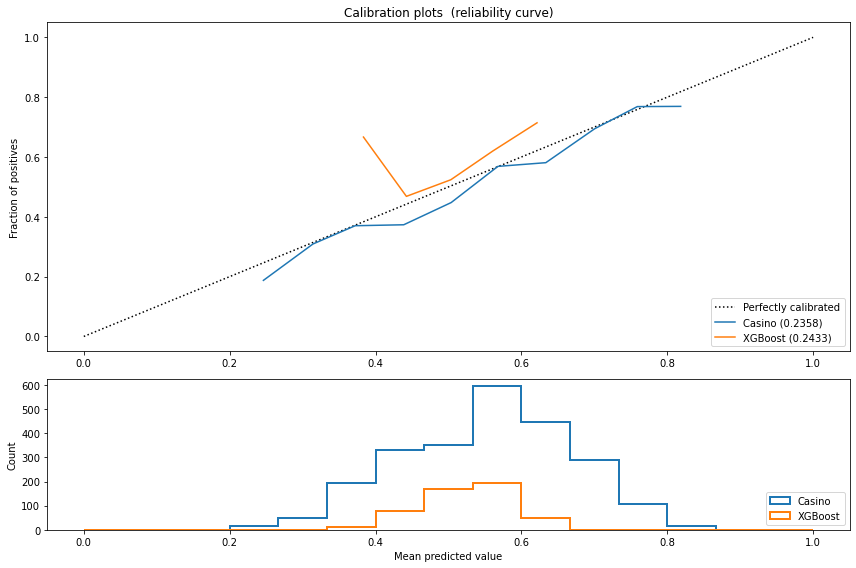

In [6]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt
import pickle

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_pred, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\t\tAccuracy:{:.4f}\t Brier Loss: {:.4f}".format(
            name, accuracy_score(y_test, y_pred), brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

outcomes,predictions,probabilities = pickle.load(open('baseline.pkl','rb'))
data = [
    (outcomes, predictions, probabilities, 'Casino'),
    (y_test,xgb_test_preds, xgb_test_proba, 'XGBoost')
]
cal_curve(data, 15)

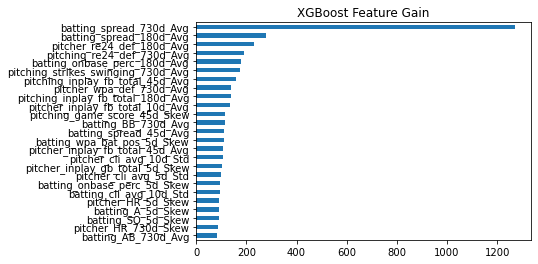

In [7]:
import pandas as pd
x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
_ = x[-25:].plot(kind='barh',title="XGBoost Feature Gain")